# Evaluate accelerometer and gyroscope data
Data of a single stroke "a one" and the movement data for a "two" have been recorded
This notebook tries to extract position data in preparation to be used as input tensor for the magic wand model

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Read the acceleration and gyroscope data files for a digit

In [2]:
stroke_type = "eight"
series_number = "1"

In [3]:
acceleration_data = []
gyroscope_data = []

In [4]:
f = open("acc_" + stroke_type + "-" + series_number + ".txt","r")
acceleration_txt = f.read().split("\n")
f.close()
# print(acceleration_txt)

In [5]:
print("No of samples: {:d}".format(len(acceleration_txt)))

No of samples: 506


In [6]:
for i in range(1,len(acceleration_txt)):
    if acceleration_txt[i] == "": # skip empty lines
        continue    
    acc_xyz = acceleration_txt[i].split(',')
    acc = [float(acc_xyz[0]),float(acc_xyz[1]),float(acc_xyz[2])]
    acceleration_data.append(acc)
for i in range(10):
    print(acceleration_data[i])

[0.0409, -0.887, 0.4988]
[0.0657, -0.8666, 0.4483]
[0.0817, -0.9169, 0.4933]
[0.0897, -0.916, 0.4799]
[0.1066, -0.9193, 0.4657]
[0.0994, -0.9292, 0.4431]
[0.0891, -0.9381, 0.4215]
[0.0861, -0.9484, 0.4053]
[0.0746, -0.9552, 0.3919]
[0.069, -0.9578, 0.384]


In [7]:
f = open("gyro_" + stroke_type + "-" + series_number + ".txt","r")
gyroscope_txt = f.read().split("\n")
f.close()

In [8]:
for i in range(1,len(gyroscope_txt)):
    if gyroscope_txt[i] == "": # skip empty lines
        continue
    gyro_xyz = gyroscope_txt[i].split(',')
    gyro = [float(gyro_xyz[0]),float(gyro_xyz[1]),float(gyro_xyz[2])]
    # print(gyro)
    gyroscope_data.append(gyro)
for i in range(10):
    print(gyroscope_data[i])

[112.5523, -84.4752, -28.1381]
[407.4831, -148.9914, 11.7801]
[427.3812, -48.6465, 31.4951]
[-35.7677, 44.4349, 6.592]
[-36.9274, 44.0077, 5.7985]
[-16.8462, 18.9215, 1.1597]
[-1.648, -0.1831, -2.5025]
[-1.1597, -0.6714, -2.7467]
[-1.2207, -0.6104, -2.8077]
[-1.0376, -1.3428, -2.9908]


In [9]:
acceleration_array = np.array(acceleration_data)
acc_x = acceleration_array[:,0]
acc_y = acceleration_array[:,1]
acc_z = acceleration_array[:,2]

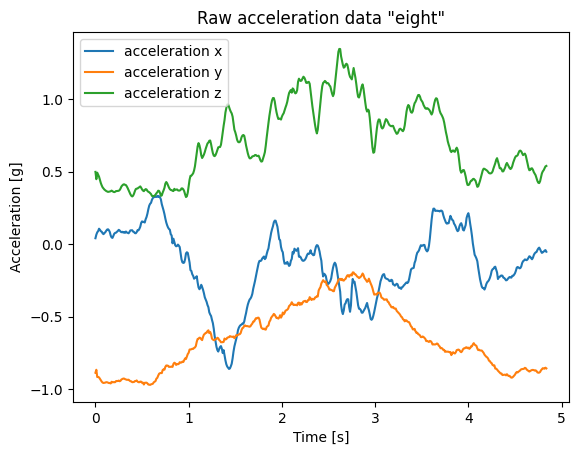

In [10]:
sample_frequency = 104.0
x = np.arange(0,len(acc_x)*1.0/sample_frequency,1.0/sample_frequency)
plt.plot(x,acc_x, label="acceleration x")
plt.plot(x,acc_y, label="acceleration y")
plt.plot(x,acc_z, label="acceleration z")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [g]")
plt.title('Raw acceleration data "' + stroke_type + '"')
plt.legend()

remove the two first values which look like outliers

In [11]:
gyroscope_data[0] = [0.0,0.0,0.0]
gyroscope_data[1] = [0.0,0.0,0.0]
gyroscope_data[2] = [0.0,0.0,0.0]
gyroscope_data[3] = [0.0,0.0,0.0]

In [12]:
gyroscope_data[:10]

[[0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [-36.9274, 44.0077, 5.7985],
 [-16.8462, 18.9215, 1.1597],
 [-1.648, -0.1831, -2.5025],
 [-1.1597, -0.6714, -2.7467],
 [-1.2207, -0.6104, -2.8077],
 [-1.0376, -1.3428, -2.9908]]

In [13]:
gyroscope_array = np.array(gyroscope_data)
gyro_x = gyroscope_array[:,0]
gyro_y = gyroscope_array[:,1]
gyro_z = gyroscope_array[:,2]

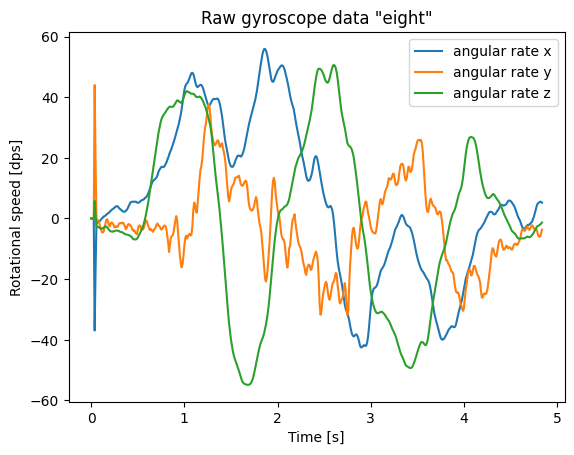

In [14]:
plt.plot(x,gyro_x, label="angular rate x")
plt.plot(x,gyro_y, label="angular rate y")
plt.plot(x,gyro_z, label="angular rate z")
plt.xlabel("Time [s]")
plt.ylabel("Rotational speed [dps]")
plt.title('Raw gyroscope data "' + stroke_type + '"')
plt.legend()

### Start evaluation
Estimate the gyroscope drift

In [15]:
current_gravity  = [0.0, 0.0, 0.0]
current_gyroscope_drift = [0.0, 0.0, 0.0]
current_velocity = [0.0,0.0,0.0]
current_position = [0.0,0.0,0.0]
data_index = 0
data_length = 600

In [16]:
def EstimateGravityDirection():
    samples_to_average = 20
    if samples_to_average >= data_index:
        samples_to_average = data_index
    #print("samples to average: {:d}".format(samples_to_average))
    start_index = (data_index + (data_length - (samples_to_average))) % data_length
    # print("Start index: {:d}".format(start_index))
    x_total = 0
    y_total = 0
    z_total = 0
    # print("Entry index: {:d}".format(start_index % data_length))
    for i in range(samples_to_average):
        index = (start_index + i) % data_length
        entry = acceleration_data[index]
        x_total += entry[0]
        y_total += entry[1]
        z_total += entry[2]
    gravity = [x_total/samples_to_average,y_total/samples_to_average,z_total/samples_to_average]
    return gravity


In [17]:
data_index = 1
gravity = EstimateGravityDirection()
print("Gravity: ",gravity)

Gravity:  [0.0409, -0.887, 0.4988]


Calculate the gravity evolution

In [18]:
gravity_evolution = []
for i in range(len(acceleration_data)-1):
    data_index += 1
    gravity_evolution.append(EstimateGravityDirection())
# print("Gravity evolution: ",gravity_evolution)

In [19]:
gravity_array = np.array(gravity_evolution)
gravity_x = gravity_array[:,0]
gravity_y = gravity_array[:,1]
gravity_z = gravity_array[:,2]

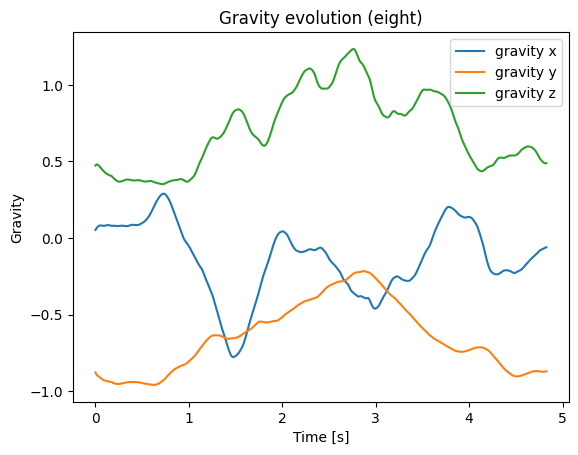

In [20]:
x_minus_1 = x[:-1] # remove last entry. The average array has 1 element less that the acceleration data array
plt.plot(x_minus_1,gravity_x, label="gravity x")
plt.plot(x_minus_1,gravity_y, label="gravity y")
plt.plot(x_minus_1,gravity_z, label="gravity z")
plt.xlabel("Time [s]")
plt.ylabel("Gravity")
plt.title('Gravity evolution (' + stroke_type + ')')
plt.legend()

In [21]:
def UpdateVelocity(new_samples, gravity):
    gravity_x = gravity[0]
    gravity_y = gravity[1]
    gravity_z = gravity[2]
    start_index = (data_index + data_length - new_samples+1) % data_length
    # print("UpdateVelocity, velocities before calc: ",velocities)
    # print("start_index: {:d}".format(start_index))
    friction_fudge = 0.98
    for i in range(new_samples):
        index = (start_index + i) % data_length
        entry = acceleration_data[index]
        # print("Acceleration entry: ",entry)
        # print("Gravity: ",gravity)
        ax = entry[0]
        ay = entry[1]
        az = entry[2]
        # remove the gravity from the acceleration values
        ax_minus_gravity = ax - gravity_x
        ay_minus_gravity = ay - gravity_y
        az_minus_gravity = az - gravity_z
        # print("acc minus gravity: ",ax_minus_gravity,ay_minus_gravity,az_minus_gravity)
        # update the velocity based on the normalized acceleration
        current_velocity[0] += ax_minus_gravity
        current_velocity[1] += ay_minus_gravity
        current_velocity[2] += az_minus_gravity
        
        # dampen the velocity slightly with a fudge facor to stop it exploding
        current_velocity[0] *= friction_fudge
        current_velocity[1] *= friction_fudge
        current_velocity[2] *= friction_fudge
        # print("Current velocity: ",current_velocity)

        # update the position estimate based on the velocity
        current_position[0] += current_velocity[0]
        current_position[1] += current_velocity[1]
        current_position[2] += current_velocity[2]
        # print("UpdateVelocity, velocities after calc: ",velocities)
        return [current_velocity[0],current_velocity[1],current_velocity[2]],[current_position[0],current_position[1],current_position[2]]

In [22]:
data_index = 0
velocities = []
positions = []
for i in range(len(acceleration_data) -1 ):
    v,p = UpdateVelocity(1,gravity_array[i])
    velocities.append(v)
    positions.append(p)
    data_index += 1
    

In [23]:
for i in range(5):
    print(velocities[i])

[-0.012152000000000001, -0.009995999999999988, 0.024744999999999993]
[-0.009034293333333339, 0.013299253333333304, -0.00694656666666672]
[0.0031023925333333166, -0.006836231733333404, 0.006152864666666601]
[0.015564744682666637, -0.02124270709866681, 0.00867580737333325]
[0.040668116455679956, -0.03401518629002687, 0.0028019578925332815]


In [24]:
velocity_array = np.array(velocities)
velocity_x = velocity_array[:,0]
velocity_y = velocity_array[:,1]
velocity_z = velocity_array[:,2]

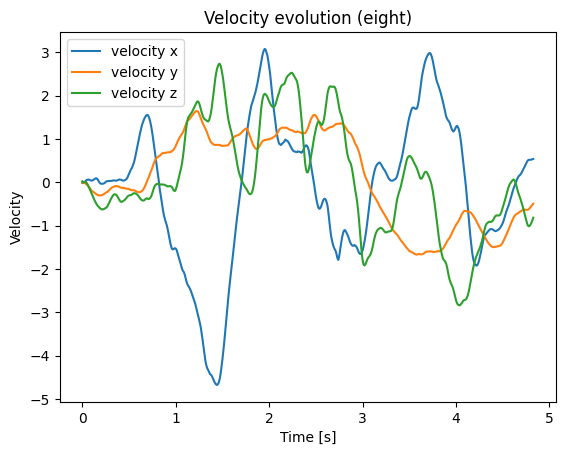

In [25]:
plt.plot(x_minus_1,velocity_x, label="velocity x")
plt.plot(x_minus_1,velocity_y, label="velocity y")
plt.plot(x_minus_1,velocity_z, label="velocity z")
plt.xlabel("Time [s]")
plt.ylabel("Velocity")
plt.title('Velocity evolution (' + stroke_type + ')')
plt.legend()

Now let's try to find the positions first as plot of the evolution of of the x,y,z values
then as a line plot in 3d

In [26]:
position_array = np.array(positions)
position_x = position_array[:,0]
position_y = position_array[:,1]
position_z = position_array[:,2]

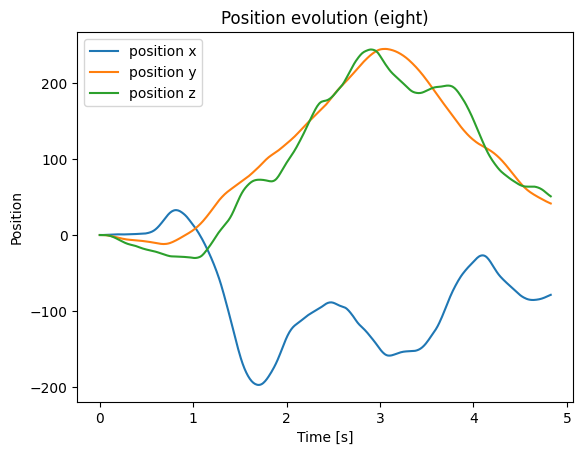

In [27]:
plt.plot(x_minus_1,position_x, label="position x")
plt.plot(x_minus_1,position_y, label="position y")
plt.plot(x_minus_1,position_z, label="position z")
plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.title('Position evolution (' + stroke_type +')')
plt.legend()

In [28]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

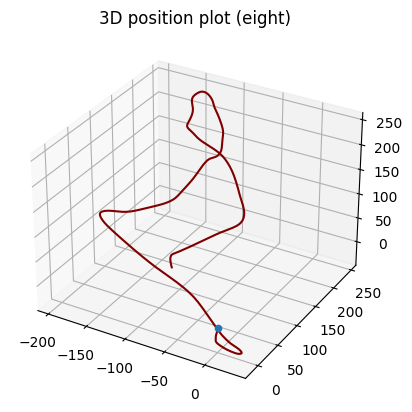

In [29]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(position_x[0],position_y[0],position_z[0])
ax.plot3D(position_x, position_y, position_z, 'maroon')
ax.set_title('3D position plot (' + stroke_type + ')')
plt.show()

In [30]:
from math import sqrt
def VectorMagnitude(vector):
    return sqrt(vector[0]*vector[0] + vector[1]*vector[1] + vector[2]*vector[2])

In [31]:
def EstimateGyroscopeDrift(drift):
    isMoving = VectorMagnitude(current_velocity) > 0.2
    if isMoving:
        #print("Moving at index {:d} vector magnitude: {:6.2f}".format(data_index,VectorMagnitude(current_velocity))) 
        return [drift[0],drift[1],drift[2]]
    
    samples_to_average = 20;
    if samples_to_average >= data_index:
        samples_to_average = data_index

    start_index = (data_index + data_length - samples_to_average + 1) % data_length
    # print("Start index : {:d}".format(start_index))

    x_total = 0.0
    y_total = 0.0
    z_total = 0.0
    for i in range(samples_to_average):
        index = (start_index + i) % data_length
        entry = gyroscope_data[index]
        x = entry[0]
        y = entry[1]
        z = entry[2]
        x_total += x
        y_total += y
        z_total += z
  
    drift[0] = x_total / samples_to_average;
    drift[1] = y_total / samples_to_average;
    drift[2] = z_total / samples_to_average;
    return [drift[0],drift[1],drift[2]]
    


In [32]:
data_index = 1
current_gyroscope_drift = [0.0,0.0,0.0]
gyroscope_drift = []
for i in range(len(velocities)):
    current_velocity = velocities[data_index-1]
    d = EstimateGyroscopeDrift(current_gyroscope_drift)
    gyroscope_drift.append(d)    
    data_index += 1

In [33]:
gyro_drift_array = np.array(gyroscope_drift)
gyro_drift_x = gyro_drift_array[:,0]
gyro_drift_y = gyro_drift_array[:,1]
gyro_drift_z = gyro_drift_array[:,2]

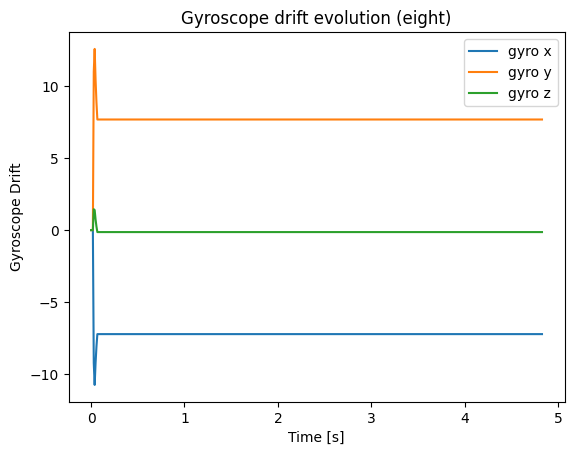

In [34]:
plt.plot(x_minus_1,gyro_drift_x, label="gyro x")
plt.plot(x_minus_1,gyro_drift_y, label="gyro y")
plt.plot(x_minus_1,gyro_drift_z, label="gyro z")
plt.xlabel("Time [s]")
plt.ylabel("Gyroscope Drift")
plt.title('Gyroscope drift evolution (' + stroke_type + ')')
plt.legend()

In [35]:
def UpdateOrientation(new_samples, gravity, drift):
    drift_x = drift[0]
    drift_y = drift[1]
    drift_z = drift[2]

    start_index = (data_index + data_length - new_samples + 1) % data_length
    # print(start_index)
    recip_sample_rate = 1.0 / sample_frequency

    for i in range(new_samples):
        index = (start_index + i) % data_length
        
        entry = gyroscope_data[index]
        dx = entry[0]
        dy = entry[1]
        dz = entry[2]

        # Try to remove sensor errors from the raw gyroscope_data
        dx_minus_drift = dx - drift_x
        dy_minus_drift = dy - drift_y
        dz_minus_drift = dz - drift_z
        
        # Convert rom degrees-per-second to appropriate units for this time interval
        dx_normalized = dx_minus_drift * recip_sample_rate
        dy_normalized = dy_minus_drift * recip_sample_rate        
        dz_normalized = dz_minus_drift * recip_sample_rate

        # Update orientation based on the gyroscope data
        previous_index = (index + data_length -1 ) % data_length
        # print("previous index: {:d}".format(previous_index))
        previous_orientation = orientation_data[index]
        current_orientation[0] = previous_orientation[0] + dx_normalized
        current_orientation[1] = previous_orientation[1] + dy_normalized
        current_orientation[2] = previous_orientation[2] + dz_normalized
        return [current_orientation[0],current_orientation[1],current_orientation[2]]

In [36]:
data_index = 1
orientation_data = []
current_orientation = [0.0,0.0,0.0]
orientation_data.append(current_orientation)
orientation_data.append(current_orientation)
for i in range(len(gyroscope_drift)-1):
    o = UpdateOrientation(1,gravity_evolution[i],gyroscope_drift[i])
    orientation_data.append(o)
    data_index += 1

In [37]:
orientation_data[0] = [0.0,0.0,0.0]
orientation_data[1] = [0.0,0.0,0.0]

Plot the orientation data

In [39]:
orientation_array = np.array(orientation_data)
orientation_x = orientation_array[:,0]
orientation_y = orientation_array[:,1]
orientation_z = orientation_array[:,2]

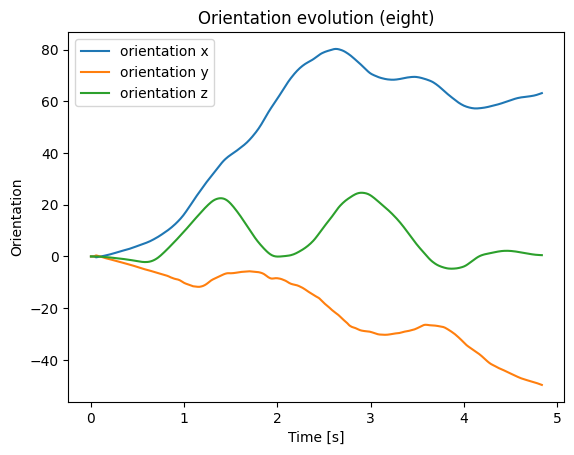

In [40]:
plt.plot(x,orientation_x, label="orientation x")
plt.plot(x,orientation_y, label="orientation y")
plt.plot(x,orientation_z, label="orientation z")
plt.xlabel("Time [s]")
plt.ylabel("Orientation")
plt.title('Orientation evolution (' + stroke_type + ')')
plt.legend()

In [41]:
def isMoving(samples_before):
    moving_threshold = 10.0
    
    if data_index - samples_before < moving_sample_count:
        # print("data index: {:d}, samples_before: {:d}".format(data_index,samples_before))
        return False
        
    total = 0.0
    start_index = (data_index - moving_sample_count + samples_before) % data_length
    print("start_index: {:d}".format(start_index))
    for i in range(moving_sample_count):
        index = (start_index + i) % data_length
        current_orientation = orientation_data[index]
        previous_index = (index + data_length - 1) % data_length
        previous_orientation = orientation_data[previous_index]
        dx = current_orientation[0] - previous_orientation[0]
        dy = current_orientation[1] - previous_orientation[1]
        dz = current_orientation[2] - previous_orientation[2]
        print(dx,dy,dz)
        mag_squared = (dx * dx) + (dy * dy) + (dz * dz)
        print("total: {:6.4f}".format(total))
        total += mag_squared
    print("mag squared: {:6.4f}".format(total))
    is_moving = total > moving_threshold
    return is_moving    

In [42]:
data_index = 5
orientation_data[0] = [0.0,0.0,0.0]
orientation_data[1] = [0.0,0.0,0.0]
moving_sample_count = 50
while not isMoving(1):
    data_index += 1
print("Moving at index: {:d}".format(data_index))
start_moving = data_index - moving_sample_count

start_index: 2
0.0 0.0 0.0
total: 0.0000
0.0 0.0 0.0
total: 0.0000
0.0 0.0 0.0
total: 0.0000
-0.26630336538461535 0.3173632211538462 0.04181610576923077
total: 0.0000
-0.05857192307692305 0.060919807692307704 -0.002230192307692308
total: 0.1734
0.07297051282051287 -0.10231522435897439 -0.03120304487179487
total: 0.1805
0.06657060439560442 -0.09172321428571428 -0.0287581043956044
total: 0.1973
0.05773605769230772 -0.07974459134615385 -0.025676562500000003
total: 0.2110
0.059496634615384625 -0.08678689903846154 -0.02743713942307692
total: 0.2213
0.06243125000000001 -0.09911189903846154 -0.029785216346153845
total: 0.2331
0.06595240384615386 -0.1073282451923077 -0.030958293269230774
total: 0.2478
0.06947355769230772 -0.11671862980769232 -0.030371754807692303
total: 0.2646
0.07182067307692308 -0.11847920673076923 -0.030371754807692303
total: 0.2840
0.07592932692307697 -0.11495805288461541 -0.028024639423076925
total: 0.3041
0.07651586538461541 -0.10380709134615385 -0.025090024038461528
tot

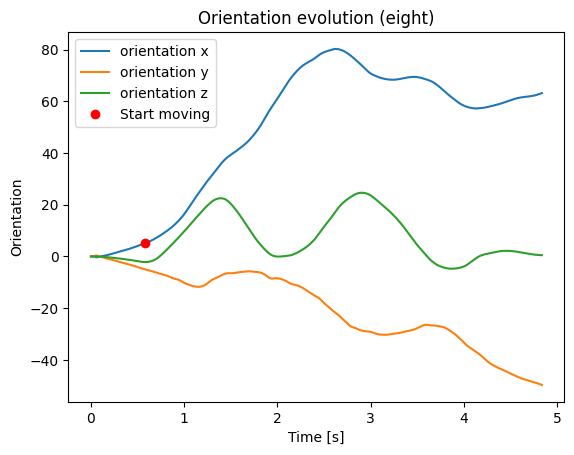

In [43]:
plt.plot(x,orientation_x, label="orientation x")
plt.plot(x,orientation_y, label="orientation y")
plt.plot(x,orientation_z, label="orientation z")
plt.plot(x[start_moving],orientation_x[start_moving],'ro',label="Start moving")
plt.xlabel("Time [s]")
plt.ylabel("Orientation")
plt.title('Orientation evolution (' + stroke_type + ')')
plt.legend()

In [44]:
def UpdateStroke(new_samples):
    minimum_stroke_length = moving_sample_count + 10
    minimum_stroke_size = 0.2

    done_just_triggered = False
    for i in range(new_samples):
        current_head = new_samples
        is_moving = isMoving(current_head)
        old_state = stroke_state
        if old_state == eWaiting or old_state == eDone:
            if is_moving:
                stroke_length = moving_sample_count
                print("Switched to drawing state at index {:d}".format(data_index))
                stroke_state = eDrawing
            elif old_state == eDrawing:
                if not is_moving:
                    if stroke_length > minimum_stroke_length:
                        print("Switched to Done state")
                        stroke_state = eDone
                    else:
                        stroke_length = 0
                        print("Switched to waiting state")
                        stroke_length = eWaiting
        is_waiting = (stroke_state == eWaiting)

        stroke_length += 1
        if stroke_length >stroke_max_length:
            stroke_length = stroke_max_length

        # only recalculate the full stroke if it is needed
        draw_last_point = ((i == new_samples -1) and (stroke_state == eDrawing))
        done_just_triggered = ((old_state != eDone) and (stroke_state == eDone)) 
        if not done_just_triggered or draw_last_point:
            continue

        start_index = (data_index  + data_length -(stroke_length + current_head)) % data_length
        x_total = 0.0
        y_total = 0.0
        z_total = 0.0

        for j in range(stroke_length):
            index = (start_index + j) % data_length
            entry = orientation[data_index]
            x_total += entry[0]
            y_total += entry[1]
            z_total = entry[2]

        x_mean = x_total / stroke_length
        y_mean = y_total / stroke_length
        z_mean = z_total / stroke_length

        range = 90.0
        gx = current_gravity[0]
        gz = current_gravity[2]
        
        gmag = sqrtf((gx * gx) + (gz * gz))
        if gmag < 0.0001:
          gmag = 0.0001
            
        ngx = gx / gmag
        ngz = gz / gmag
  
        xaxisz = -ngz
        xaxisy = -ngx

        yaxisz = -ngx
        yaxisy = ngz      

        stroke_transmit_length = stroke_length / stroke_transmit_stride
        
        for j in range(stroke_transmit_length):
            orientation_index = (start_index + (j * stroke_transmit_stride) % gyroscope_data_length)
            orientation_entry = orientation_data[orientation_index]  

            orientation_x = orientation_entry[0]
            orientation_y = orientation_entry[1]
            orientation_z = orientation_entry[2]

            nx = (orientation_x - x_mean) / range
            ny = (orientation_y - y_mean) / range
            nz = (orientation_z - z_mean) / range
    
            x_axis = xaxisz * nz + xaxisy * ny
            y_axis = yaxisz * nz + yaxisy * ny   

            stroke_index = j * 2;
            stroke_entry = stroke_points[stroke_index]
      
            unchecked_x = int(x_axis*128.0)

            if (unchecked_x > 127):
                stored_x = 127
            elif unchecked_x < -128:
                stored_x = -128
            else:
                stored_x = unchecked_x
            stroke_entry[0] = stored_x;
      
            unchecked_y = int(y_axis * 128.0)
            if unchecked_y > 127:
                stored_y = 127
            elif unchecked_y < -128:
                stored_y = -128
            else:
                stored_y = unchecked_y
            stroke_entry[1] = stored_y

            is_first = (j == 0)
            if is_first or (x_axis < x_min):
                x_min = x_axis
            if is_first or (y_axis < y_min):
                y_min = y_axis
      
            if is_first or (x_axis > x_max):
                x_max = x_axis;
            if is_first or (y_axis > y_max):
                y_max = y_axis
       

In [45]:
eWaiting = 0
eDrawing = 1
eDone = 2
stroke_state = eWaiting
done_just_triggered = False

In [46]:
stroke_length = 0
stroke_stride = 2
data_index = 0
UpdateStroke(1)

UnboundLocalError: local variable 'range' referenced before assignment